# Temporal difference prediction and control

In this notebook, you will implement temporal difference approaches to prediction and control described in [Sutton and Barto's book, Introduction to Reinforcement Learning](http://incompleteideas.net/book/the-book-2nd.html). We will use the grid ```World``` class from the previous lectures.

### Imports

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys  # We use sys to get the max value of a float
import pandas as pd  # We only use pandas for displaying tables nicely
from IPython.display import display

pd.options.display.float_format = "{:,.3f}".format

### ```World``` class and globals

The ```World``` is a grid represented as a two-dimensional array of characters where each character can represent free space, an obstacle, or a terminal. Each non-obstacle cell is associated with a reward that an agent gets for moving to that cell (can be 0). The size of the world is _width_ $\times$ _height_ characters.

A _state_ is a tuple $(x,y)$.

An empty world is created in the ```__init__``` method. Obstacles, rewards and terminals can then be added with ```add_obstacle``` and ```add_reward```.

To calculate the next state of an agent (that is, an agent is in some state $s = (x,y)$ and performs and action, $a$), ```get_next_state()```should be called.

In [3]:
# Globals:
ACTIONS = ("up", "down", "left", "right")

# Rewards, terminals and obstacles are characters:
REWARDS = {" ": 0, ".": 0.1, "+": 10, "-": -10}
TERMINALS = ("+", "-")  # Note a terminal should also have a reward assigned
OBSTACLES = "#"

# Discount factor
gamma = 1

# The probability of a random move:
rand_move_probability = 0


class World:
    def __init__(self, width, height):
        self.width = width
        self.height = height
        # Create an empty world where the agent can move to all cells
        self.grid = np.full((width, height), " ", dtype="U1")
        # Create an empty windy grid
        self.windy_grid = {}
        self.initialize_windy_grid()

    def initialize_windy_grid(self):
        for x in range(self.width):
            for y in range(self.height):
                self.windy_grid[(x, y)] = (" ", 0)

    def add_obstacle(self, start_x, start_y, end_x=None, end_y=None):
        """
        Create an obstacle in either a single cell or rectangle.
        """
        if end_x == None:
            end_x = start_x
        if end_y == None:
            end_y = start_y

        self.grid[start_x : end_x + 1, start_y : end_y + 1] = OBSTACLES[0]

    def add_wind(self, x, y, wind_dir, wind_strength):
        """
        Add wind to a cell.
        x, y: coordinates of the cell
        wind_dir: one of the four cardinal directions
        wind_strength: the strength of the wind
        """
        self.windy_grid[(x, y)] = (wind_dir, wind_strength)

    def add_reward(self, x, y, reward):
        assert reward in REWARDS, f"{reward} not in {REWARDS}"
        self.grid[x, y] = reward

    def add_terminal(self, x, y, terminal):
        assert terminal in TERMINALS, f"{terminal} not in {TERMINALS}"
        self.grid[x, y] = terminal

    def is_obstacle(self, x, y):
        if x < 0 or x >= self.width or y < 0 or y >= self.height:
            return True
        else:
            return self.grid[x, y] in OBSTACLES

    def is_terminal(self, x, y):
        return self.grid[x, y] in TERMINALS

    def get_reward(self, x, y):
        """
        Return the reward associated with a given location
        """
        return REWARDS[self.grid[x, y]]

    def get_next_state(self, current_state, action):
        """
        Get the next state given a current state and an action. The outcome can be
        stochastic  where rand_move_probability determines the probability of
        ignoring the action and performing a random move.
        """
        assert action in ACTIONS, f"Unknown acion {action} must be one of {ACTIONS}"

        x, y = current_state

        # If our current state is a terminal, there is no next state
        if self.grid[x, y] in TERMINALS:
            return None

        # Check of a random action should be performed:
        if np.random.rand() < rand_move_probability:
            action = np.random.choice(ACTIONS)

        if action == "up":
            y -= 1
        elif action == "down":
            y += 1
        elif action == "left":
            x -= 1
        elif action == "right":
            x += 1
        elif action == "up-left":
            x -= 1
            y -= 1
        elif action == "up-right":
            x += 1
            y -= 1
        elif action == "down-left":
            x -= 1
            y += 1
        elif action == "down-right":
            x += 1
            y += 1

        # If the next state is an obstacle, stay in the current state
        return (x, y) if not self.is_obstacle(x, y) else current_state

    def get_next_state_windy(self, current_state, action):
        """
        Get the next state given a current state and an action. The outcome can be
        stochastic  where rand_move_probability determines the probability of
        ignoring the action and performing a random move.
        """
        assert action in ACTIONS, f"Unknown acion {action} must be one of {ACTIONS}"

        x, y = current_state

        # If our current state is a terminal, there is no next state
        if self.grid[x, y] in TERMINALS:
            return None

        # Check of a random action should be performed:
        if np.random.rand() < rand_move_probability:
            action = np.random.choice(ACTIONS)

        if self.windy_grid[x, y][0] == "up":
            y -= self.windy_grid[x, y][1]
        elif self.windy_grid[x, y][0] == "down":
            y += self.windy_grid[x, y][1]
        elif self.windy_grid[x, y][0] == "left":
            x -= self.windy_grid[x, y][1]
        elif self.windy_grid[x, y][0] == "right":
            x += self.windy_grid[x, y][1]

        if action == "up":
            y -= 1
        elif action == "down":
            y += 1
        elif action == "left":
            x -= 1
        elif action == "right":
            x += 1
        elif action == "up-left":
            x -= 1
            y -= 1
        elif action == "up-right":
            x += 1
            y -= 1
        elif action == "down-left":
            x -= 1
            y += 1
        elif action == "down-right":
            x += 1
            y += 1

        # Limit values to be within the grid
        x = min(max(x, 0), self.width - 1)
        y = min(max(y, 0), self.height - 1)

        # If the next state is an obstacle, stay in the current state
        return (x, y) if not self.is_obstacle(x, y) else current_state

## A simple world and a simple policy

In [4]:
ACTIONS = ("up", "down", "left", "right")
world = World(2, 3)

# Since we only focus on episodic tasks, we must have a terminal state that the
# agent eventually reaches
world.add_terminal(1, 2, "+")


def equiprobable_random_policy(x, y):
    return {k: 1 / len(ACTIONS) for k in ACTIONS}


print(world.grid.T)

[[' ' ' ']
 [' ' ' ']
 [' ' '+']]


## Exercise: TD prediction

You should implement TD prediction for estimating $V≈v_\pi$. See page 120 of [Introduction to Reinforcement Learning](http://incompleteideas.net/book/the-book-2nd.html).


To implement TD prediction, the agent has to interact with the world for a certain number of episodes. However, unlike in the Monte Carlo case, we do not rely on complete sample runs, but instead update estimates (for prediction and control) and the policy (for control only) each time step in an episode.


Below, you can see the code for running an episode, with a TODO where you have to add your code for prediction. Also, play with the parameters ```alpha``` and ```EPISODES```, you will typically need a lot more than 10 episodes for an agent to learn anything.

In [5]:
# Global variable to keep track of current estimates
V = {}

# Our step size / learing rate
alpha = 0.05

# Discount factor
gamma = 0.9

# Episodes to run
EPISODES = 10


def TD_prediction_run_episode(world, policy, start_state):
    current_state = start_state
    while not world.is_terminal(*current_state):
        # Get the possible actions and their probabilities that our policy says
        # that the agent should perform in the current state:
        possible_actions = policy(*current_state)

        # Pick a weighted random action:
        action = random.choices(
            population=list(possible_actions.keys()),
            weights=possible_actions.values(),
            k=1,
        )

        # Get the next state from the world
        next_state = world.get_next_state(current_state, action[0])

        # Get the reward for performing the action
        reward = world.get_reward(*next_state)

        if current_state not in V:
            V[current_state] = 0
        if next_state not in V:
            V[current_state] = 0

        print(
            f"Current state (S) = {current_state}, next_state S' = {next_state}, reward = {reward}"
        )

        # Move the agent to the new state
        current_state = next_state


for episode in range(EPISODES):
    print(f"Episode {episode + 1 }/{EPISODES}:")
    TD_prediction_run_episode(world, equiprobable_random_policy, (0, 0))

Episode 1/10:
Current state (S) = (0, 0), next_state S' = (0, 0), reward = 0
Current state (S) = (0, 0), next_state S' = (0, 0), reward = 0
Current state (S) = (0, 0), next_state S' = (0, 1), reward = 0
Current state (S) = (0, 1), next_state S' = (0, 0), reward = 0
Current state (S) = (0, 0), next_state S' = (0, 1), reward = 0
Current state (S) = (0, 1), next_state S' = (1, 1), reward = 0
Current state (S) = (1, 1), next_state S' = (1, 0), reward = 0
Current state (S) = (1, 0), next_state S' = (1, 0), reward = 0
Current state (S) = (1, 0), next_state S' = (1, 0), reward = 0
Current state (S) = (1, 0), next_state S' = (0, 0), reward = 0
Current state (S) = (0, 0), next_state S' = (1, 0), reward = 0
Current state (S) = (1, 0), next_state S' = (1, 0), reward = 0
Current state (S) = (1, 0), next_state S' = (1, 0), reward = 0
Current state (S) = (1, 0), next_state S' = (0, 0), reward = 0
Current state (S) = (0, 0), next_state S' = (1, 0), reward = 0
Current state (S) = (1, 0), next_state S'

## Exercise: SARSA

Implement and test SARSA with an $\epsilon$-greedy policy. See page 130 of [Introduction to Reinforcement Learning](http://incompleteideas.net/book/the-book-2nd.html) on different worlds. Make sure that it is easy to show a learnt policy (most probable action in each state).


In [6]:
def greedy_policy(Q, state, epsilon):
    a = {action: epsilon / len(ACTIONS) for action in ACTIONS}

    _, max_value = max(Q[state].items(), key=lambda x: x[1])
    # Count cells that have the same max value
    max_value_count = sum(Q[state][action] == max_value for action in ACTIONS)
    for action in ACTIONS:
        if Q[state][action] == max_value:
            a[action] += (1 - epsilon) / max_value_count

    return a


def SARSA(
    world: World,
    start_state,
    policy,
    Q,
    gamma=0.9,
    alpha=0.1,
    epsilon=0.1,
    use_wind=False,
):
    steps = 1
    # Initialize the starting action
    possible_actions = policy(Q, start_state, epsilon)

    # Initialize the starting action
    current_action = random.choices(
        population=list(possible_actions.keys()),
        weights=list(possible_actions.values()),
        k=1,
    )[0]

    current_state = start_state
    while not world.is_terminal(*current_state):
        # Get the next state, action, and reward
        if use_wind:
            next_state = world.get_next_state_windy(current_state, current_action)
        else:
            next_state = world.get_next_state(current_state, current_action)

        possible_actions = policy(Q, current_state, epsilon)

        next_action = random.choices(
            population=list(possible_actions.keys()),
            weights=list(possible_actions.values()),
            k=1,
        )[0]

        reward = world.get_reward(*next_state)

        # Update the Q-value for the current state-action pair
        Q[current_state][current_action] += alpha * (
            reward
            + gamma * Q[next_state][next_action]
            - Q[current_state][current_action]
        )

        # Move to the next state and action
        current_action = next_action
        current_state = next_state
        steps += 1

    return Q, steps

In [7]:
ACTIONS = ("up", "down", "left", "right")
world = World(3, 3)
world.add_terminal(1, 2, "+")
display(pd.DataFrame(world.grid.T))

nb_episodes = 10000
Q = {}
for x in range(world.width):
    for y in range(world.height):
        Q[(x, y)] = {action: 0.0 for action in ACTIONS}

for i in range(nb_episodes):
    Q, step = SARSA(
        world=world,
        start_state=(0, 0),
        policy=greedy_policy,
        Q=Q,
        gamma=0.9,
        alpha=0.1,
        epsilon=0.1,
        use_wind=False,
    )

final_policy = np.full((world.width, world.height), "          ")
for i in range(world.width):
    for j in range(world.height):
        if world.is_terminal(i, j):
            final_policy[(i, j)] = "termnal"
        elif world.is_obstacle(i, j):
            final_policy[(i, j)] = "#"
        else:
            final_policy[(i, j)] = max(Q[(i, j)], key=Q[(i, j)].get)
display(pd.DataFrame(final_policy.T))

,0,1,2
0,,,
1,,,
2,,+,


,0,1,2
0,down,down,down
1,down,down,down
2,right,termnal,left


## Exercise: Windy Gridworld

Implement the Windy Gridworld (Example 6.5 on page 130 in the book) and test your SARSA implementation on the Windy Gridworld, first with the four actions (```up, down, left, right```) that move the agent in the cardinal directions, and then with King's moves as described in Exercise 6.9. How long does it take to learn a good policy for different values of $\alpha$ and $\epsilon$?

### Without King's Moves (Windy Gridworld)

In [8]:
ACTIONS = ("up", "down", "left", "right")
world = World(width=5, height=5)

# Add wind to the grid in x=2 with strength 1
for i in range(world.height):
    world.add_wind(2, i, "up", 1)

world.add_terminal(4, 4, "+")

display(pd.DataFrame(world.grid.T))

windy_grid = np.full((world.width, world.height), "          ")
for x in range(world.width):
    for y in range(world.height):
        if world.windy_grid[x, y][1] >= 1:
            windy_grid[x, y] = (
                f"{world.windy_grid[(x, y)][0]} : {world.windy_grid[(x, y)][1]}"
            )
display(pd.DataFrame(windy_grid.T))

nb_episodes = 10000
Q = {}
for x in range(world.width):
    for y in range(world.height):
        Q[(x, y)] = {action: 0.0 for action in ACTIONS}

for i in range(nb_episodes):
    Q, steps = SARSA(
        world=world,
        start_state=(0, 0),
        policy=greedy_policy,
        Q=Q,
        gamma=0.9,
        alpha=0.1,
        epsilon=0.1,
        use_wind=True,
    )

final_policy = np.full((world.width, world.height), "          ")
for i in range(world.width):
    for j in range(world.height):
        if world.is_terminal(i, j):
            final_policy[(i, j)] = "termnal"
        elif world.is_obstacle(i, j):
            final_policy[(i, j)] = "#"
        else:
            final_policy[(i, j)] = max(Q[(i, j)], key=Q[(i, j)].get)
display(pd.DataFrame(final_policy.T))

,0,1,2,3,4
0,,,,,
1,,,,,
2,,,,,
3,,,,,
4,,,,,+


,0,1,2,3,4
0,,,up : 1,,
1,,,up : 1,,
2,,,up : 1,,
3,,,up : 1,,
4,,,up : 1,,


,0,1,2,3,4
0,right,right,right,right,down
1,right,right,right,down,down
2,right,right,right,down,down
3,up,right,right,right,down
4,up,up,right,right,termnal


### With King's Moves (Windy Gridworld)

In [9]:
ACTIONS = (
    "up",
    "down",
    "left",
    "right",
    "up-left",
    "up-right",
    "down-left",
    "down-right",
)
world = World(width=5, height=5)

# Add wind to the grid in x=2 with strength 1
for i in range(world.height):
    world.add_wind(2, i, "up", 1)

world.add_terminal(4, 4, "+")

display(pd.DataFrame(world.grid.T))

windy_grid = np.full((world.width, world.height), "          ")
for x in range(world.width):
    for y in range(world.height):
        if world.windy_grid[x, y][1] >= 1:
            windy_grid[x, y] = (
                f"{world.windy_grid[(x, y)][0]} : {world.windy_grid[(x, y)][1]}"
            )
display(pd.DataFrame(windy_grid.T))

nb_episodes = 10000
Q = {}
for x in range(world.width):
    for y in range(world.height):
        Q[(x, y)] = {action: 0.0 for action in ACTIONS}

for i in range(nb_episodes):
    Q, steps = SARSA(
        world=world,
        start_state=(0, 0),
        policy=greedy_policy,
        Q=Q,
        gamma=0.9,
        alpha=0.1,
        epsilon=0.1,
        use_wind=True,
    )

final_policy = np.full((world.width, world.height), "          ")
for i in range(world.width):
    for j in range(world.height):
        if world.is_terminal(i, j):
            final_policy[(i, j)] = "termnal"
        elif world.is_obstacle(i, j):
            final_policy[(i, j)] = "#"
        else:
            final_policy[(i, j)] = max(Q[(i, j)], key=Q[(i, j)].get)
display(pd.DataFrame(final_policy.T))

,0,1,2,3,4
0,,,,,
1,,,,,
2,,,,,
3,,,,,
4,,,,,+


,0,1,2,3,4
0,,,up : 1,,
1,,,up : 1,,
2,,,up : 1,,
3,,,up : 1,,
4,,,up : 1,,


,0,1,2,3,4
0,right,down-right,up-right,down,down-right
1,up-right,right,down-right,down-right,down-right
2,up-right,up-right,right,down-right,down-right
3,up,up-right,down-right,down-right,down
4,up,up-right,down-right,down-right,termnal


In [10]:
def q_learning(world: World, start_state, policy, Q, gamma=0.9, alpha=0.1, epsilon=0.1):
    current_state = start_state
    steps = 0
    while not world.is_terminal(*current_state):
        # Choose the next action based on the epsilon-greedy policy
        possible_actions = policy(Q, current_state, epsilon)

        # Initialize the starting action
        current_action = random.choices(
            population=list(possible_actions.keys()),
            weights=list(possible_actions.values()),
            k=1,
        )[0]

        # Get the next state and reward
        next_state = world.get_next_state(current_state, current_action)
        reward = world.get_reward(*next_state)

        # Find the best next action in the next state
        best_next_action_value = max(Q[next_state].values())

        # Update the Q-table
        Q[current_state][current_action] += alpha * (
            reward + gamma * best_next_action_value - Q[current_state][current_action]
        )

        # Update the state
        current_state = next_state
        steps += 1

    # Return the Q-table after training to be used as a policy
    return Q, steps


# %%[markdown]
# # Compare SARSA and Q-learning

In [11]:
ACTIONS = ("up", "down", "left", "right")
world = World(15, 15)
world.add_terminal(14, 14, "+")
world.add_obstacle(6, 7)
world.add_obstacle(2, 2)
display(pd.DataFrame(world.grid.T))

n_episodes = 250
instances = 50
steps_total_qlear = [0] * n_episodes
steps_total_sarsa = [0] * n_episodes


for i in tqdm(range(instances)):
    Q = {}
    steps_temp = []
    for x in range(world.width):
        for y in range(world.height):
            Q[(x, y)] = {action: 0.0 for action in ACTIONS}

    for i in range(n_episodes):
        Q, steps = SARSA(
            world=world,
            start_state=(0, 0),
            policy=greedy_policy,
            Q=Q,
            gamma=0.9,
            alpha=0.1,
            epsilon=0.1,
        )
        steps_temp.append(steps)

    steps_total_sarsa = [sum(values) for values in zip(steps_total_sarsa, steps_temp)]

for i in tqdm(range(instances)):
    Q = {}
    steps_temp = []
    for x in range(world.width):
        for y in range(world.height):
            Q[(x, y)] = {action: 0.0 for action in ACTIONS}

    for i in range(n_episodes):
        Q, steps = q_learning(
            world=world,
            start_state=(0, 0),
            policy=greedy_policy,
            Q=Q,
            gamma=0.9,
            alpha=0.1,
            epsilon=0.1,
        )
        steps_temp.append(steps)
    steps_total_qlear = [sum(values) for values in zip(steps_total_qlear, steps_temp)]

steps_total_qlear = [value / instances for value in steps_total_qlear]
steps_total_sarsa = [value / instances for value in steps_total_sarsa]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,,,,,,,,,,,,
1,,,,,,,,,,,,,,,
2,,,#,,,,,,,,,,,,
3,,,,,,,,,,,,,,,
4,,,,,,,,,,,,,,,
5,,,,,,,,,,,,,,,
6,,,,,,,,,,,,,,,
7,,,,,,,#,,,,,,,,
8,,,,,,,,,,,,,,,
9,,,,,,,,,,,,,,,


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.91it/s]


[]

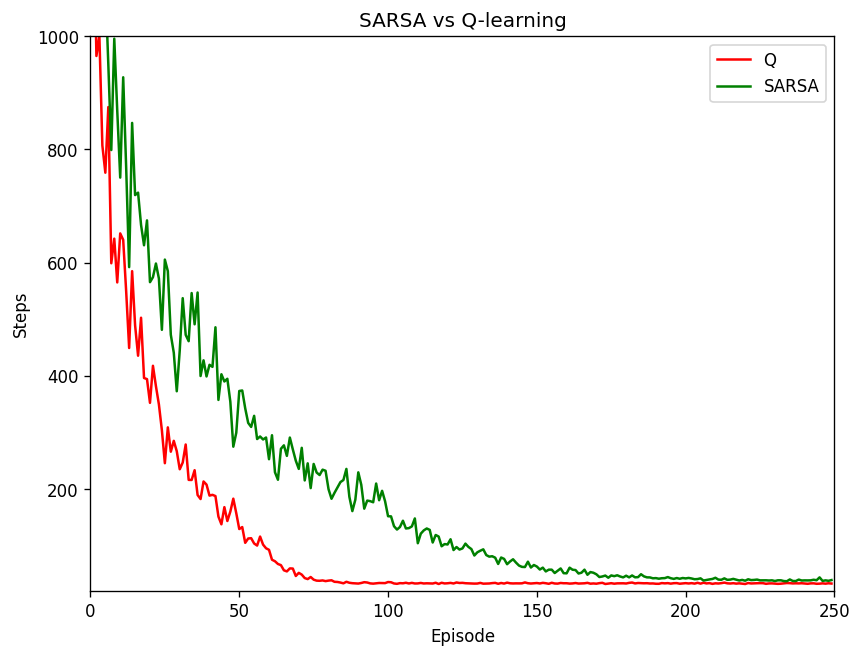

In [12]:
#
fig = plt.figure(figsize=(8, 6), dpi=120)
ax = fig.add_subplot(1, 1, 1)
plt.ylim(20, 1000)
plt.xlim(0, n_episodes)

# Plot the
ax.plot(steps_total_qlear, "r", markersize=1)
ax.plot(steps_total_sarsa, "g", markersize=1)

plt.xlabel("Episode")
plt.ylabel("Steps")
plt.legend(
    [
        "Q",
        "SARSA",
    ]
)

plt.title("SARSA vs Q-learning")

plt.plot()

In [13]:
ACTIONS = ("up", "down", "left", "right")
world = World(7, 7)
world.add_terminal(6, 6, "+")
world.add_obstacle(2, 3)
world.add_obstacle(4, 1)
display(pd.DataFrame(world.grid.T))

n_episodes = 250
Q = {}
for x in range(world.width):
    for y in range(world.height):
        Q[(x, y)] = {action: 0.0 for action in ACTIONS}

for i in range(n_episodes):
    Q, step = SARSA(
        world=world,
        start_state=(0, 0),
        policy=greedy_policy,
        Q=Q,
        gamma=0.9,
        alpha=0.1,
        epsilon=0.1,
    )
final_policy = np.full((world.width, world.height), "          ")
final_values = np.full((world.width, world.height), 0.0)
for i in range(world.width):
    for j in range(world.height):
        if world.is_terminal(i, j):
            final_policy[(i, j)] = "termnal"
        elif world.is_obstacle(i, j):
            final_policy[(i, j)] = "#"
        else:
            final_policy[(i, j)] = max(Q[(i, j)], key=Q[(i, j)].get)
            final_values[(i, j)] = max(Q[(i, j)].items(), key=lambda x: x[1])[1]
display(pd.DataFrame(final_policy.T))
display(pd.DataFrame(final_values.T))

,0,1,2,3,4,5,6
0,,,,,,,
1,,,,,#,,
2,,,,,,,
3,,,#,,,,
4,,,,,,,
5,,,,,,,
6,,,,,,,+


,0,1,2,3,4,5,6
0,right,right,right,down,left,left,up
1,right,right,right,down,#,up,up
2,up,right,right,down,down,down,down
3,up,down,#,down,down,down,down
4,right,right,down,down,down,down,down
5,up,right,right,down,down,down,down
6,up,right,right,right,right,right,termnal


,0,1,2,3,4,5,6
0,0.520,0.735,0.847,2.033,0.442,0.035,0.000
1,0.007,0.621,1.621,2.400,0.000,0.000,0.000
2,0.000,0.013,0.917,2.949,2.324,0.070,0.010
3,0.000,0.000,0.000,3.195,3.468,0.714,0.276
4,0.000,0.001,0.013,3.939,5.246,2.642,2.480
5,0.000,0.000,0.516,4.360,6.677,6.313,9.529
6,0.000,0.055,4.969,6.658,8.292,10.000,0.000


In [14]:
ACTIONS = ("up", "down", "left", "right")
world = World(7, 7)
world.add_terminal(6, 6, "+")
world.add_obstacle(2, 3)
world.add_obstacle(4, 1)
display(pd.DataFrame(world.grid.T))

n_episodes = 250
Q = {}
for x in range(world.width):
    for y in range(world.height):
        Q[(x, y)] = {action: 0.0 for action in ACTIONS}

for i in range(n_episodes):
    Q, step = q_learning(
        world=world,
        start_state=(0, 0),
        policy=greedy_policy,
        Q=Q,
        gamma=0.9,
        alpha=0.1,
        epsilon=0.1,
    )
final_policy = np.full((world.width, world.height), "          ")
final_values = np.full((world.width, world.height), 0.0)
for i in range(world.width):
    for j in range(world.height):
        if world.is_terminal(i, j):
            final_policy[(i, j)] = "termnal"
        elif world.is_obstacle(i, j):
            final_policy[(i, j)] = "#"
        else:
            final_policy[(i, j)] = max(Q[(i, j)], key=Q[(i, j)].get)
            final_values[(i, j)] = max(Q[(i, j)].items(), key=lambda x: x[1])[1]
display(pd.DataFrame(final_policy.T))
display(pd.DataFrame(final_values.T))
# %%[markdown]
# # Compare SARSA $\alpha$ and $\epsilon$

,0,1,2,3,4,5,6
0,,,,,,,
1,,,,,#,,
2,,,,,,,
3,,,#,,,,
4,,,,,,,
5,,,,,,,
6,,,,,,,+


,0,1,2,3,4,5,6
0,down,left,up,up,up,up,up
1,down,down,up,up,#,up,up
2,right,down,left,down,left,up,up
3,right,down,#,right,down,left,down
4,right,right,right,right,right,right,down
5,up,right,up,up,right,right,down
6,up,up,up,up,up,right,termnal


,0,1,2,3,4,5,6
0,3.135,0.519,0.000,0.000,0.000,0.000,0.000
1,3.486,3.002,0.000,0.000,0.000,0.000,0.000
2,3.874,4.304,1.709,0.196,0.003,0.000,0.000
3,3.325,4.783,0.000,2.210,5.884,2.523,3.315
4,2.444,5.314,5.905,6.561,7.290,8.100,9.000
5,0.000,0.157,2.862,2.170,1.874,7.566,10.000
6,0.000,0.000,0.000,0.000,0.000,1.900,0.000


In [15]:
ACTIONS = ("up", "down", "left", "right")
world = World(10, 10)
world.add_terminal(9, 9, "+")
world.add_obstacle(6, 7)
world.add_obstacle(2, 2)
display(pd.DataFrame(world.grid.T))

n_episodes = 150
instances = 150
steps_total_sarsa_001 = [0] * n_episodes
steps_total_sarsa_01 = [0] * n_episodes
steps_total_sarsa_1 = [0] * n_episodes


for i in tqdm(range(instances)):
    Q = {}
    steps_temp = []
    for x in range(world.width):
        for y in range(world.height):
            Q[(x, y)] = {action: 0.0 for action in ACTIONS}

    for i in range(n_episodes):
        Q, steps = SARSA(
            world=world,
            start_state=(0, 0),
            policy=greedy_policy,
            Q=Q,
            gamma=0.9,
            alpha=0.01,
            epsilon=0.1,
        )
        steps_temp.append(steps)

    steps_total_sarsa_001 = [
        sum(values) for values in zip(steps_total_sarsa_001, steps_temp)
    ]


for i in tqdm(range(instances)):
    Q = {}
    steps_temp = []
    for x in range(world.width):
        for y in range(world.height):
            Q[(x, y)] = {action: 0.0 for action in ACTIONS}

    for i in range(n_episodes):
        Q, steps = SARSA(
            world=world,
            start_state=(0, 0),
            policy=greedy_policy,
            Q=Q,
            gamma=0.9,
            alpha=0.1,
            epsilon=0.1,
        )
        steps_temp.append(steps)

    steps_total_sarsa_01 = [
        sum(values) for values in zip(steps_total_sarsa_01, steps_temp)
    ]

for i in tqdm(range(instances)):
    Q = {}
    steps_temp = []
    for x in range(world.width):
        for y in range(world.height):
            Q[(x, y)] = {action: 0.0 for action in ACTIONS}

    for i in range(n_episodes):
        Q, steps = SARSA(
            world=world,
            start_state=(0, 0),
            policy=greedy_policy,
            Q=Q,
            gamma=0.9,
            alpha=1.0,
            epsilon=0.1,
        )
        steps_temp.append(steps)

    steps_total_sarsa_1 = [
        sum(values) for values in zip(steps_total_sarsa_1, steps_temp)
    ]

steps_total_sarsa_001 = [value / instances for value in steps_total_sarsa_001]
steps_total_sarsa_01 = [value / instances for value in steps_total_sarsa_01]
steps_total_sarsa_1 = [value / instances for value in steps_total_sarsa_1]

,0,1,2,3,4,5,6,7,8,9
0,,,,,,,,,,
1,,,,,,,,,,
2,,,#,,,,,,,
3,,,,,,,,,,
4,,,,,,,,,,
5,,,,,,,,,,
6,,,,,,,,,,
7,,,,,,,#,,,
8,,,,,,,,,,
9,,,,,,,,,,+


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:11<00:00, 12.75it/s]


[]

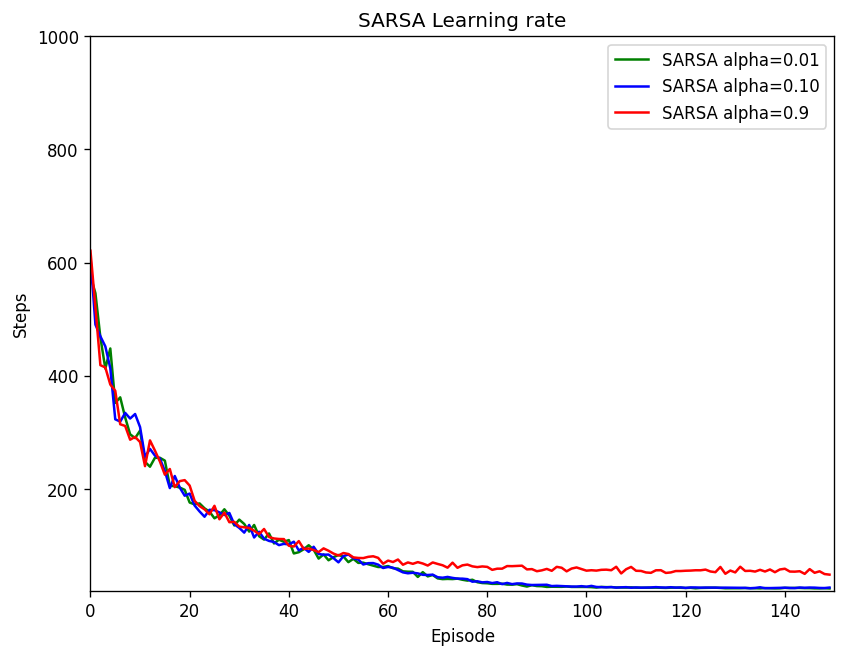

In [16]:
fig = plt.figure(figsize=(8, 6), dpi=120)
ax = fig.add_subplot(1, 1, 1)
plt.ylim(20, 1000)
plt.xlim(0, n_episodes)

# Plot the
ax.plot(steps_total_sarsa_001, "g", markersize=1)
ax.plot(steps_total_sarsa_01, "b", markersize=1)
ax.plot(steps_total_sarsa_1, "r", markersize=1)

plt.xlabel("Episode")
plt.ylabel("Steps")
plt.legend(
    [
        "SARSA alpha=0.01",
        "SARSA alpha=0.10",
        "SARSA alpha=1.0",
    ]
)

plt.title("SARSA Learning rate")

plt.plot()
# %%[markdown]
# # Compare Q-learning $\alpha$ and $\epsilon$

In [17]:
ACTIONS = ("up", "down", "left", "right")
world = World(10, 10)
world.add_terminal(9, 9, "+")
world.add_obstacle(6, 7)
world.add_obstacle(2, 2)
display(pd.DataFrame(world.grid.T))

n_episodes = 150
instances = 150
steps_total_qlearning_001 = [0] * n_episodes
steps_total_qlearning_01 = [0] * n_episodes
steps_total_qlearning_1 = [0] * n_episodes


for i in tqdm(range(instances)):
    Q = {}
    steps_temp = []
    for x in range(world.width):
        for y in range(world.height):
            Q[(x, y)] = {action: 0.0 for action in ACTIONS}

    for i in range(n_episodes):
        Q, steps = q_learning(
            world=world,
            start_state=(0, 0),
            policy=greedy_policy,
            Q=Q,
            gamma=0.9,
            alpha=0.01,
            epsilon=0.1,
        )
        steps_temp.append(steps)

    steps_total_qlearning_001 = [
        sum(values) for values in zip(steps_total_qlearning_001, steps_temp)
    ]


for i in tqdm(range(instances)):
    Q = {}
    steps_temp = []
    for x in range(world.width):
        for y in range(world.height):
            Q[(x, y)] = {action: 0.0 for action in ACTIONS}

    for i in range(n_episodes):
        Q, steps = q_learning(
            world=world,
            start_state=(0, 0),
            policy=greedy_policy,
            Q=Q,
            gamma=0.9,
            alpha=0.1,
            epsilon=0.1,
        )
        steps_temp.append(steps)

    steps_total_qlearning_01 = [
        sum(values) for values in zip(steps_total_qlearning_01, steps_temp)
    ]

for i in tqdm(range(instances)):
    Q = {}
    steps_temp = []
    for x in range(world.width):
        for y in range(world.height):
            Q[(x, y)] = {action: 0.0 for action in ACTIONS}

    for i in range(n_episodes):
        Q, steps = q_learning(
            world=world,
            start_state=(0, 0),
            policy=greedy_policy,
            Q=Q,
            gamma=0.9,
            alpha=1.0,
            epsilon=0.1,
        )
        steps_temp.append(steps)

    steps_total_qlearning_1 = [
        sum(values) for values in zip(steps_total_qlearning_1, steps_temp)
    ]

steps_total_qlearning_001 = [value / instances for value in steps_total_qlearning_001]
steps_total_qlearning_01 = [value / instances for value in steps_total_qlearning_01]
steps_total_qlearning_1 = [value / instances for value in steps_total_qlearning_1]

,0,1,2,3,4,5,6,7,8,9
0,,,,,,,,,,
1,,,,,,,,,,
2,,,#,,,,,,,
3,,,,,,,,,,
4,,,,,,,,,,
5,,,,,,,,,,
6,,,,,,,,,,
7,,,,,,,#,,,
8,,,,,,,,,,
9,,,,,,,,,,+


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:06<00:00, 23.84it/s]


[]

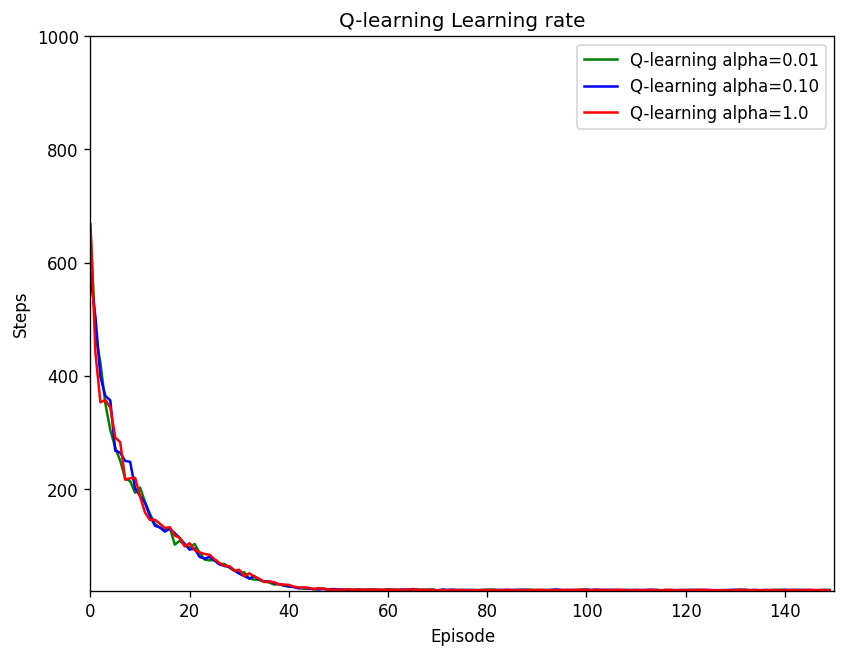

In [18]:
fig = plt.figure(figsize=(8, 6), dpi=120)
ax = fig.add_subplot(1, 1, 1)
plt.ylim(20, 1000)
plt.xlim(0, n_episodes)

# Plot the
ax.plot(steps_total_qlearning_001, "g", markersize=1)
ax.plot(steps_total_qlearning_01, "b", markersize=1)
ax.plot(steps_total_qlearning_1, "r", markersize=1)

plt.xlabel("Episode")
plt.ylabel("Steps")
plt.legend(
    [
        "Q-learning alpha=0.01",
        "Q-learning alpha=0.10",
        "Q-learning alpha=1.0",
    ]
)

plt.title("Q-learning Learning rate")

plt.plot()